In [28]:
"""
Importing required libraries
"""
import sys
import sklearn
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.decomposition import FastICA, PCA
from sklearn import random_projection
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import adjusted_mutual_info_score,mutual_info_score,adjusted_rand_score,homogeneity_completeness_v_measure
from time import time
from scipy.io.arff import loadarff 
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
from sklearn.mixture import GaussianMixture
import os
from matplotlib.colors import LogNorm
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
random_state = np.random.RandomState(17)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dataset 
Refrence:
- https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

## Dataset Attribute Information:
Dataset name: Messidor (Diabetic Retinopathy Debrecen)
following description of fetures are obtainbed from: https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

- 0) quality of image (Binart 0:Bad 1: acceptable)
- 1) pre-screening indication of disease 0: no sign 1: disease is present
- 2-7) " The results of MA detection. Each feature value stand for the
        number of MAs found at the confidence levels alpha = 0.5, . . . , 1, respectively".
- 8-15) similar to (2-7) for exudates. see refrence for more information.
- 16) The euclidean distance feture of patients retina
- 17) optic disc diameter.
- 18) AM/FM based class (binary).
- 19) 1 = contains signs disease, 0 = no signs

In [31]:
messidor_data_path = os.path.join("Data", "messidor_features.arff")
messidor_data = loadarff(messidor_data_path)
messidor = pd.DataFrame(messidor_data[0])
messidor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
0        1151 non-null float64
1        1151 non-null float64
2        1151 non-null float64
3        1151 non-null float64
4        1151 non-null float64
5        1151 non-null float64
6        1151 non-null float64
7        1151 non-null float64
8        1151 non-null float64
9        1151 non-null float64
10       1151 non-null float64
11       1151 non-null float64
12       1151 non-null float64
13       1151 non-null float64
14       1151 non-null float64
15       1151 non-null float64
16       1151 non-null float64
17       1151 non-null float64
18       1151 non-null float64
Class    1151 non-null object
dtypes: float64(19), object(1)
memory usage: 180.0+ KB


## Load/Split/Process Data:

In [34]:
messidor_train_set, messidor_test_set = train_test_split(messidor, test_size=0.2, random_state=17)
# Separate predictors and labels for messidor data
messidor_train_features = messidor_train_set.drop("Class",axis=1)
messidor_train_labels = messidor_train_set["Class"].copy()
# identifying the categorical and numerical data for messidor data
messidor_cat_attrs = ['0','1','18']
messidor_num_attrs = [c for c in messidor_train_features.columns if c not in messidor_cat_attrs ]
messidor_train_labels.value_counts()

# preprocessing the messidor data
pipeline = ColumnTransformer([
        ("num", StandardScaler(), messidor_num_attrs),
        ("cat", OneHotEncoder(), messidor_cat_attrs),
    ])
    
X = pipeline.fit_transform(messidor_train_features)
ordinal_encoder = LabelEncoder()
y = ordinal_encoder.fit_transform(messidor_train_labels)
# messidor test set preprocessing
messidor_test_features = messidor_test_set.drop("Class",axis=1)
messidor_test_prep = pipeline.transform(messidor_test_features)
messidor_test_labels = messidor_test_set["Class"].copy()
messidor_test_labels_prep = ordinal_encoder.transform(messidor_test_labels)

In [37]:
def plot_clusters(X, y=None,s=4):
    # plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=s)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_data(X,y_true=None):
    # plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # plt.plot(X[:, 0], X[:, 1], 'k.',color=y_true, markersize=2)
    plt.scatter(X[:, 0], X[:, 1], c=y_true,s=3)
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X,y_true=None, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,y_true)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


Saving figure messidor_plot


<Figure size 800x400 with 0 Axes>

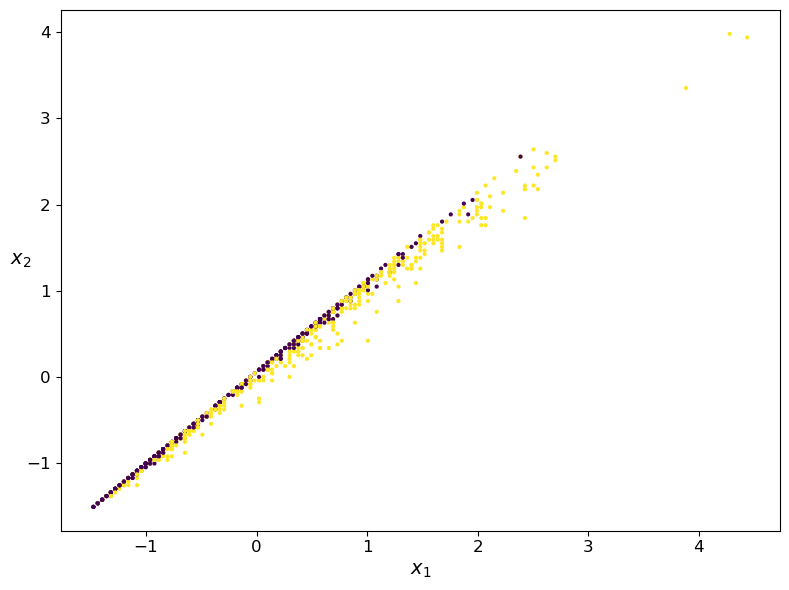

In [40]:
plt.figure(figsize=(8, 4))
plot_clusters(X,y)
save_fig("messidor_plot")
plt.show()

# Dimensionality Reduction (DR)

## PCA:

In [43]:
pca = PCA()
pca.fit(X)
cum_sum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cum_sum>=0.95)+1
d

7

Text(0, 0.5, '$Eigenvalues$')

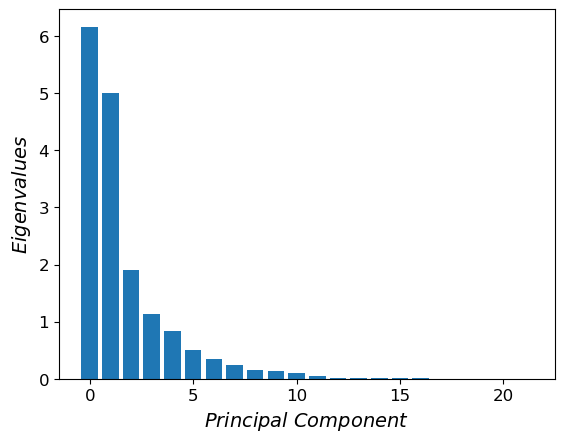

In [46]:
eigenvalues = pca.explained_variance_
plt.bar(np.arange(eigenvalues.shape[0]),eigenvalues)
plt.xlabel("$Principal$ $Component$", fontsize=14)
plt.ylabel("$Eigenvalues$", fontsize=14)

In [124]:
plt.figure(figsize=(6,4))
plt.plot(cum_sum, linewidth=3)
plt.axis([0, 50, 0, 1.1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
save_fig("PCA_messidor_explained_variance_plot")
plt.show()

Saving figure PCA_messidor_explained_variance_plot


In [52]:
pca = PCA(n_components=d,random_state=9)
X_DR_pca = pca.fit_transform(X)

In [55]:
pca.explained_variance_ratio_

array([0.37091015, 0.30109215, 0.1147883 , 0.06820308, 0.05059398,
       0.02983856, 0.02046627])

In [58]:
np.sum(pca.explained_variance_ratio_)

0.9558924942792367

### Eigenvalues

In [61]:
# Scikit-Learn PCA class automatically center the data
cov_matrix = pca.explained_variance_
eigenvalues = pca.explained_variance_

In [64]:
# We center the data and compute the sample covariance matrix.
n_samples = X.shape[0]
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
    print("eigenvalue_1=",np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print("eigenvalue_2=",eigenvalue)

eigenvalue_1= 6.156913973843006
eigenvalue_2= 6.163613553792793
eigenvalue_1= 4.997971677187255
eigenvalue_2= 5.003410166498658
eigenvalue_1= 1.905425621557799
eigenvalue_2= 1.9074989900252202
eigenvalue_1= 1.132135363679963
eigenvalue_2= 1.1333672846415288
eigenvalue_1= 0.8398335570599897
eigenvalue_2= 0.8407474129436251
eigenvalue_1= 0.4953044934012985
eigenvalue_2= 0.49584345367703464
eigenvalue_1= 0.3397292813170507
eigenvalue_2= 0.3400989540932419


Text(0, 0.5, '$Eigenvalues$')

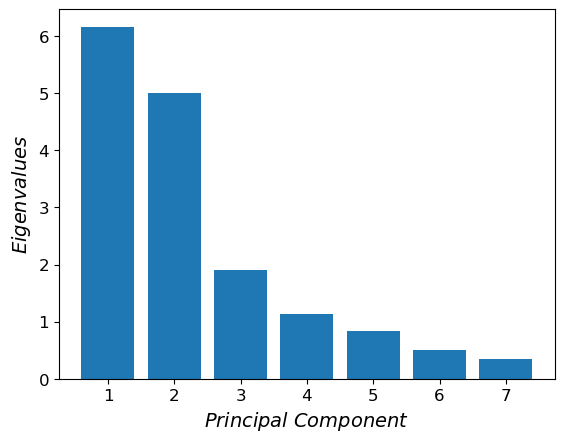

In [67]:
plt.bar(np.arange(1,d+1),eigenvalues)
plt.xlabel("$Principal$ $Component$", fontsize=14)
plt.ylabel("$Eigenvalues$", fontsize=14)

# Clustering: 

## 1- _K-Means_

In [70]:
X_DR = X_DR_pca.copy()

### Optimum Number of Clusters

### Elbow Method:

In [73]:
kmeans_with_var_k = [KMeans(n_clusters=k, random_state=9).fit(X_DR) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_with_var_k]

Saving figure PCA_messidor_inertia_vs_k_plot


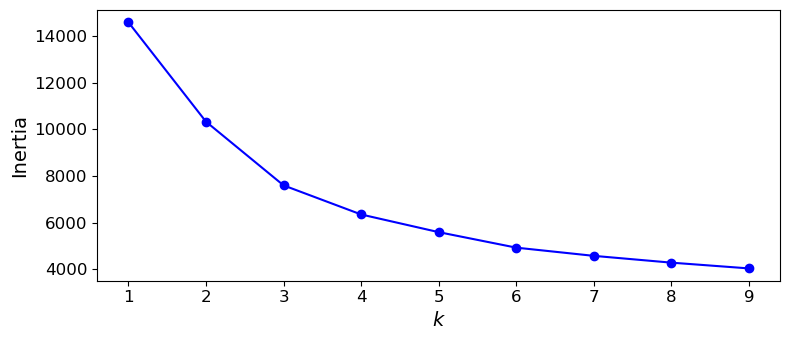

In [76]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
save_fig("PCA_messidor_inertia_vs_k_plot")
plt.show()

### Silhouette score :

In [79]:
silhouette_scores = [silhouette_score(X_DR, model.labels_) for model in kmeans_with_var_k[1:]]

Saving figure PCA_messidor_silhouette_score_vs_k_plot


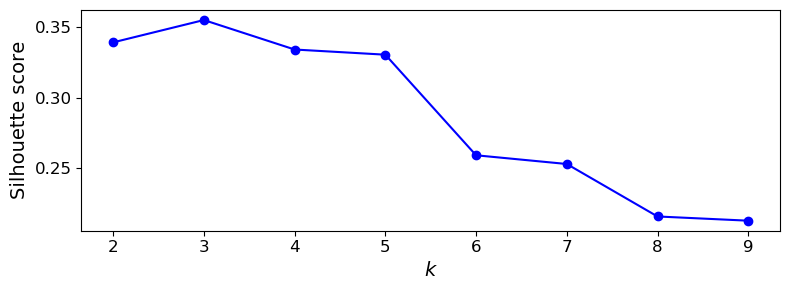

In [82]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("PCA_messidor_silhouette_score_vs_k_plot")
plt.show()

Based on the result of Elbow analysis and silhouette score k=3 is the optimum number of clusters

Saving figure PCA_messidor_silhouette_analysis_plot


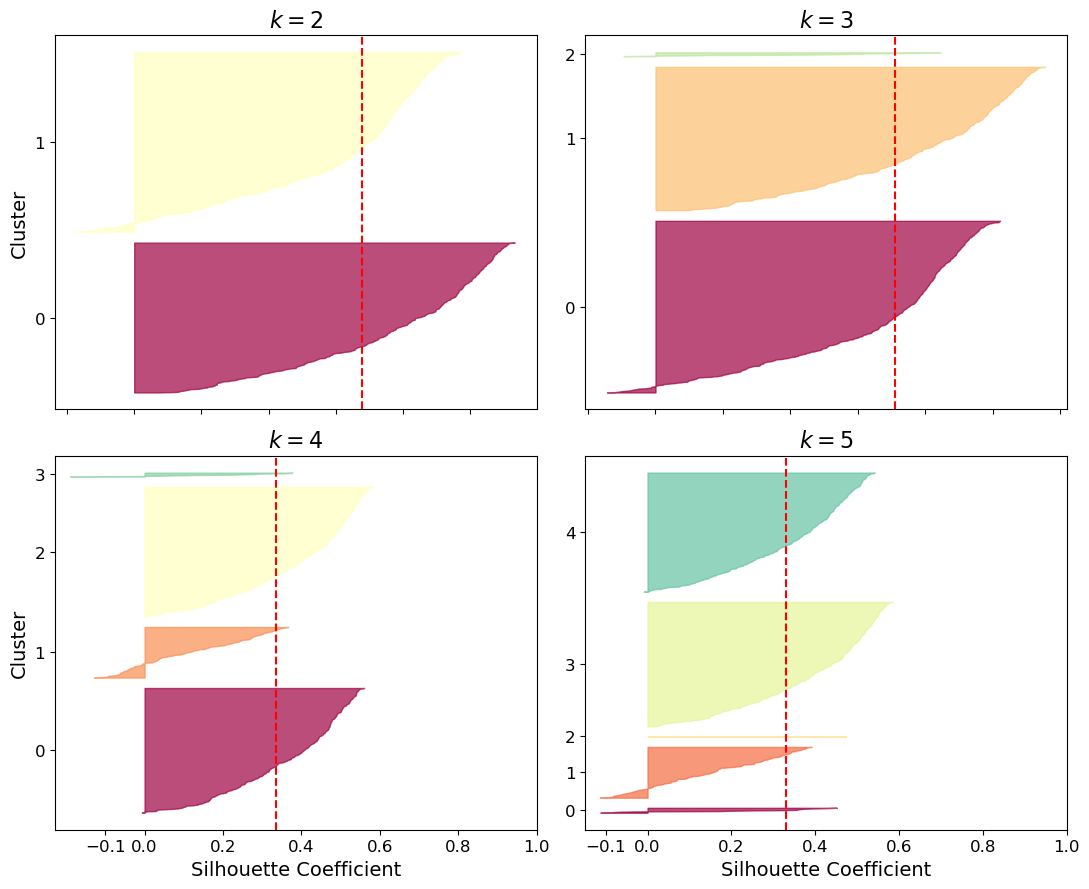

In [85]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_with_var_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_DR, y_pred)

    padding = len(X_DR) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("PCA_messidor_silhouette_analysis_plot")
plt.show()

In [88]:
# Model with optimnal k value
kmeans_optimum = kmeans_with_var_k[2]
y_pred = kmeans_optimum.fit_predict(X_DR)

### Evaluation

In [91]:
# adjusted_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score,mutual_info_score,adjusted_rand_score,homogeneity_completeness_v_measure
adjusted_mutual_info_score(y,y_pred)

0.015938107317294493

In [94]:
# adjusted Rand index
adjusted_rand_score(y,y_pred)

0.005093206154678738

In [97]:
# Homogeneity, completeness and V-measure
homogeneity_completeness_v_measure(y,y_pred)

(0.01821240578877458, 0.01676962153996091, 0.017461260866322863)

Computing t-SNE embedding


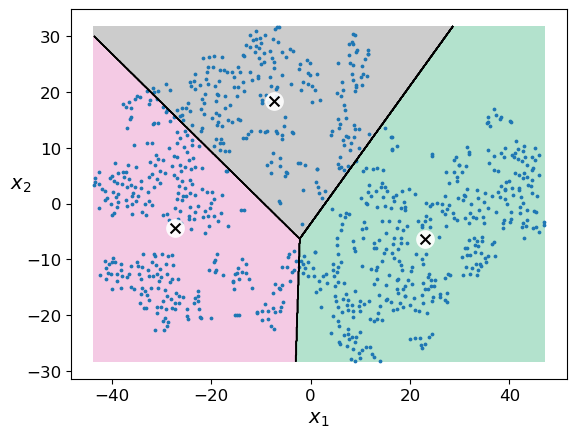

In [100]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_DR)
kmeans = KMeans(n_clusters=3, random_state=9)
kmeans.fit(X_tsne)
y_pred_tsne = kmeans.fit_predict(X_tsne)
plot_decision_boundaries(kmeans,X_tsne)

In [103]:
pca_viz = PCA(n_components=2)
pca_viz.fit(X_DR)
X_DR_pca_viz = pca_viz.fit_transform(X_DR)

In [106]:
pca_viz.explained_variance_ratio_

array([0.38802497, 0.31498536])

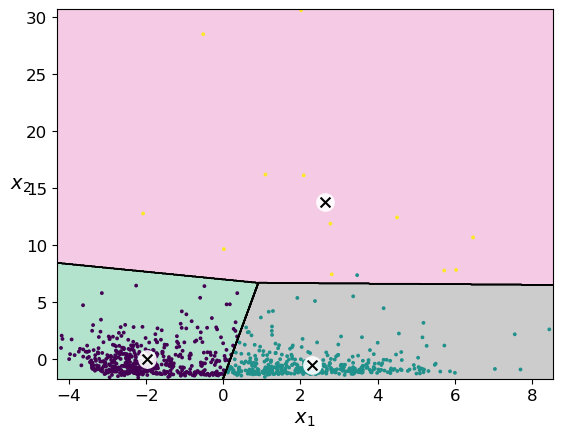

In [109]:
kmeans_pca_viz = KMeans(n_clusters=3, random_state=9)
kmeans_pca_viz.fit(X_DR_pca_viz)
plot_decision_boundaries(kmeans_pca_viz,X_DR_pca_viz,y_true=y_pred)

Saving figure PCA_messidor_K_means_cluster_TsnE


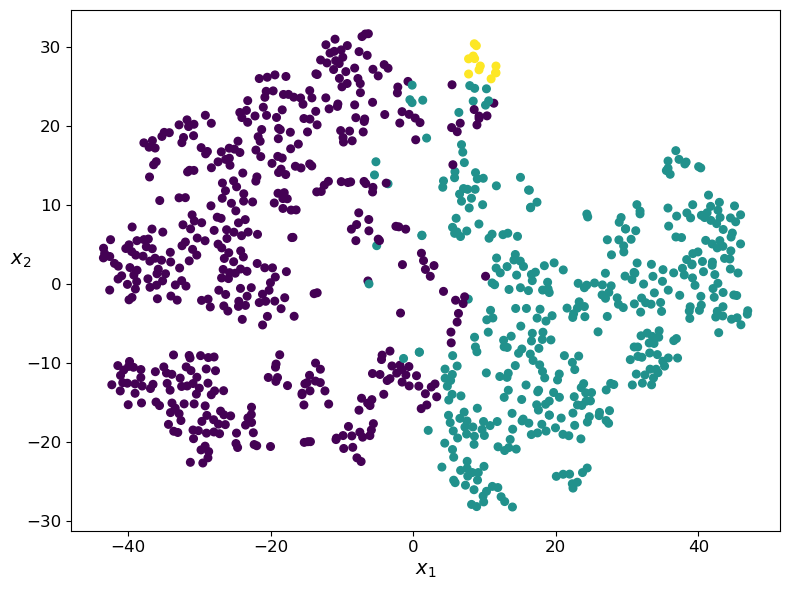

In [112]:
plot_clusters(X_tsne,y_pred,s=30)
save_fig("PCA_messidor_K_means_cluster_TsnE")

In [114]:
plot_clusters(X_DR_pca_viz,y_pred,s=30)
save_fig("PCA_messidor_K_means_cluster_PCA")

Saving figure PCA_messidor_K_means_cluster_PCA


# 2- _Gaussian Mixture (EM)_

In [116]:
g_mix = GaussianMixture(n_components=3, n_init=10, random_state=42)
g_mix.fit(X_DR)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

## - Optimum Number of Clusters

In [118]:
g_mix_with_var_k = [GaussianMixture(n_components=k, n_init=10, random_state=9).fit(X_DR) for k in range(1, 11)]

In [120]:
# calculating the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) for various k values.
bic_per_k = [model.bic(X_DR) for model in g_mix_with_var_k]
aics_per_k = [model.aic(X_DR) for model in g_mix_with_var_k]

Saving figure PCA_messidor_aic_bic_vs_k_plot


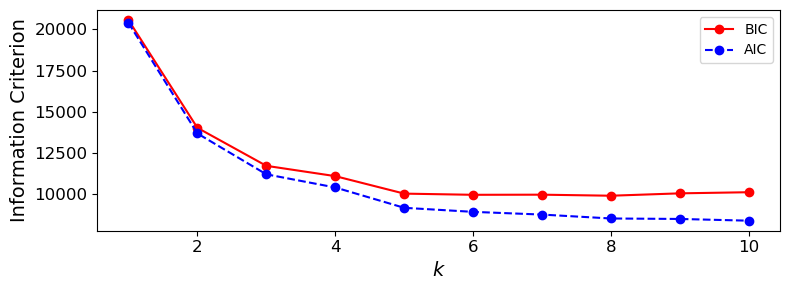

In [122]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bic_per_k, "ro-", label="BIC")
plt.plot(range(1, 11), aics_per_k, "bo--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.legend()
save_fig("PCA_messidor_aic_bic_vs_k_plot")
plt.show()

In [125]:
bic_per_k[4],aics_per_k[9]

(10014.58042348344, 8368.004241203416)

In [127]:
min_bic = np.infty
cov_type = ["full", "tied", "spherical", "diag"]
bic_lst = {"full":[], "tied":[], "spherical":[], "diag":[]}
for k in range(1, 11):
    temp=[]
    for covariance_type in cov_type:
        gm = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=9).fit(X_DR)
        bic = gm.bic(X_DR)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type
            best_gm=gm
        bic_lst[covariance_type].append(bic)

best_k,best_covariance_type

(8, 'full')

In [129]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)

    bar_width = total_width / n_bars

    bars = []

    for i, (name, values) in enumerate(data.items()):
  
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

Saving figure PCA_messidor_bic_vs_k


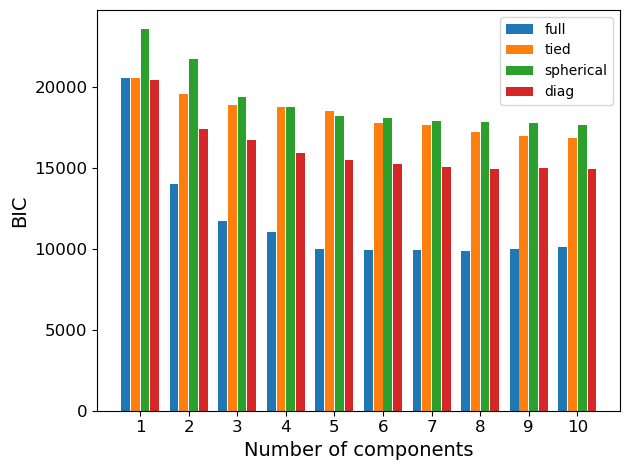

In [131]:
fig, ax = plt.subplots()
n_comp=np.arange(1, 11)
ax.set_xticks(np.arange(len(bic_lst['full'])))
ax.set_xticklabels(n_comp)
bar_plot(ax, bic_lst, total_width=.8, single_width=.9)

plt.xlabel('Number of components')
plt.ylabel('BIC')
save_fig("PCA_messidor_bic_vs_k")
plt.show()

Saving figure PCA_messidor_aic_bic_vs_k_plot_optimum


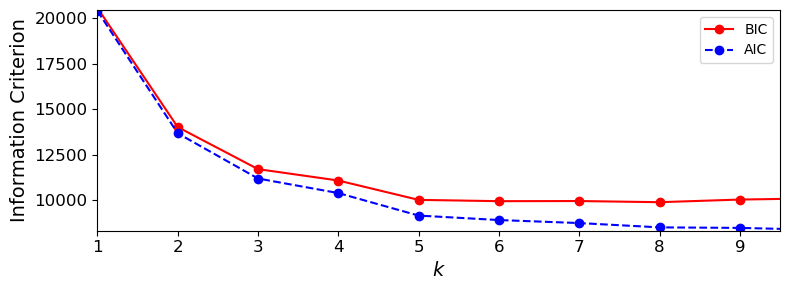

In [133]:
g_mix_with_var_k = [GaussianMixture(n_components=k, n_init=10,covariance_type=best_covariance_type, random_state=9).fit(X_DR) for k in range(1, 11)]
# calculating the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) for various k values.
bic_per_k = [model.bic(X_DR) for model in g_mix_with_var_k]
aics_per_k = [model.aic(X_DR) for model in g_mix_with_var_k]
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bic_per_k, "ro-", label="BIC")
plt.plot(range(1, 11), aics_per_k, "bo--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics_per_k) - 50, np.max(aics_per_k) + 50])
plt.legend()
save_fig("PCA_messidor_aic_bic_vs_k_plot_optimum")
plt.show()

In [135]:
bgm = BayesianGaussianMixture(n_components=20, n_init=10, random_state=9)
bgm.fit(X_DR)
np.round(bgm.weights_, 2)

array([0.  , 0.  , 0.02, 0.2 , 0.  , 0.01, 0.06, 0.01, 0.01, 0.  , 0.07,
       0.04, 0.  , 0.08, 0.47, 0.02, 0.  , 0.01, 0.01, 0.  ])

## Optimum Model

In [137]:
gm_optimum = GaussianMixture(n_components=best_k, n_init=10, covariance_type= best_covariance_type,random_state=9).fit(X_DR)
y_pred_gm = gm_optimum.predict(X_DR)

## Evaluation

In [138]:
# adjusted_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score,mutual_info_score,adjusted_rand_score,homogeneity_completeness_v_measure
adjusted_mutual_info_score(y,y_pred_gm)

0.03904520332788563

In [139]:
# adjusted Rand index
adjusted_rand_score(y,y_pred_gm)

0.012789738139585612

In [140]:
# Homogeneity, completeness and V-measure
homogeneity_completeness_v_measure(y,y_pred_gm)

(0.07705513187651183, 0.02888144366672118, 0.042015015854746596)

In [141]:
def plot_gaussian_mixture(clusterer, X,y_true = None, resolution=1000, show_ylabels=True):
    plt.figure(figsize=(8, 6))
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    ax.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    # plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    

    scatter = ax.scatter(X[:, 0], X[:, 1],c=y_true if y_true is not None else 'k'
     ,s=4)

    # produce a legend with the unique colors from the scatter
    if y_true is not None:
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
        ax.add_artist(legend1)
    # plt.scatter(X[:, 0], X[:, 1],c=y,s=)

    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure PCA_messidor_gaussian_mixtures


<Figure size 800x600 with 0 Axes>

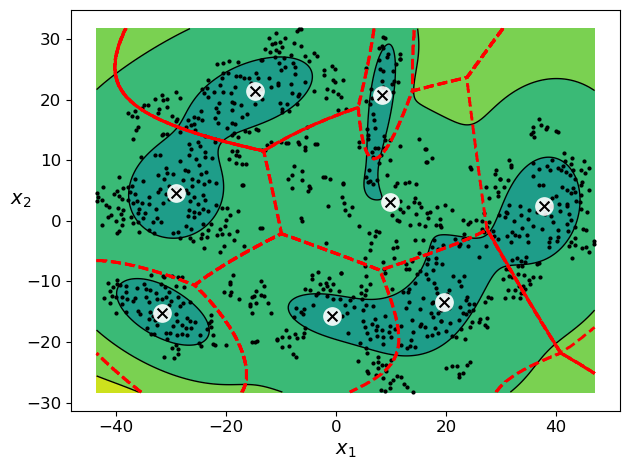

In [142]:

gm_viz = GaussianMixture(n_components=best_k, n_init=10, covariance_type= best_covariance_type,random_state=9).fit(X_tsne)
plot_gaussian_mixture(gm_viz, X_tsne)

save_fig("PCA_messidor_gaussian_mixtures")
plt.show()

Saving figure PCA_messidor_gaussian_mixtures_cluster_TsnE


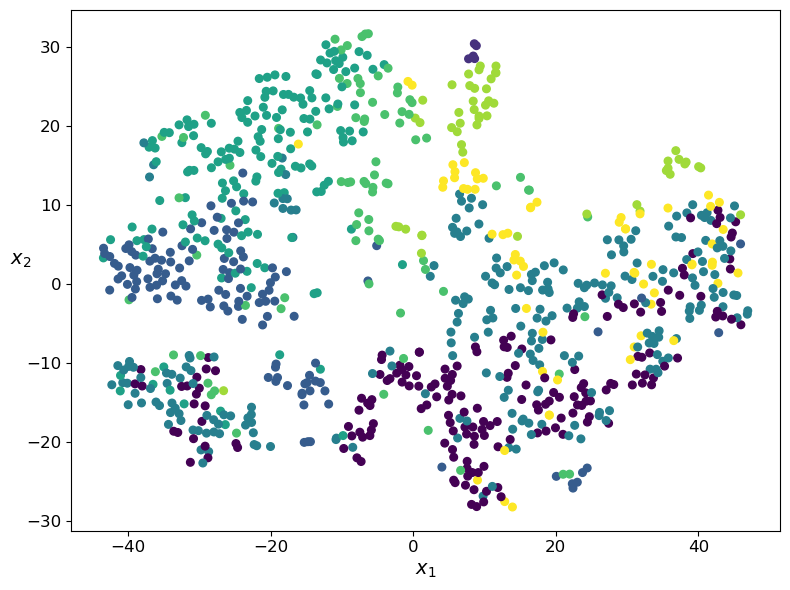

In [143]:
plot_clusters(X_tsne,y_pred_gm,30)
save_fig("PCA_messidor_gaussian_mixtures_cluster_TsnE")

Saving figure PCA_messidor_gaussian_mixtures_cluster_PCA


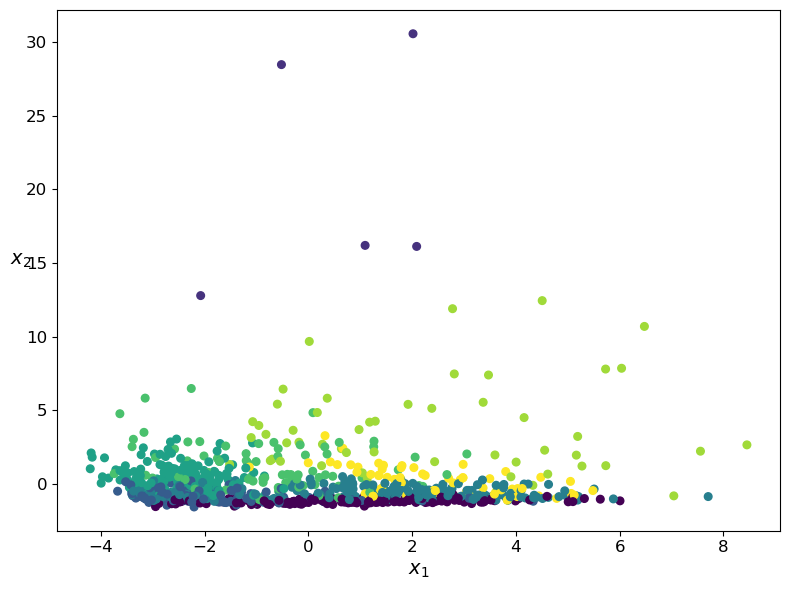

In [144]:
plot_clusters(X_DR_pca_viz,y_pred_gm,30)
save_fig("PCA_messidor_gaussian_mixtures_cluster_PCA")